# 6.5.1 Best Subset Selection

In [1]:
# imports and setup
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain, combinations
import statsmodels.api as sm

pd.set_option('precision', 2) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

In [2]:
hitters = pd.read_csv('../datasets/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'

hitters = hitters.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]] # push salary at the end
hitters['League'] = pd.get_dummies(hitters['League']).iloc[:, 0]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:, 0]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:, 0]


X = hitters.iloc[:, 0:19]
y = hitters.iloc[:, 19]

In [ ]:
# adapted from: 
# https://songhuiming.github.io/pages/2016/07/12/variable-selection-in-python/
# and:
# http://www.science.smith.edu/~jcrouser/SDS293/labs/
# takes a f**in' long time

k_features = 1

sub = []
reg = []
kft = []
n_features = X.shape[1]

for k_features in range(1, 20):
    subsets = chain(combinations(range(n_features), k_features))

    best_score = np.inf

    for subset in subsets:
        lin_reg = sm.OLS(y, sm.add_constant(X.iloc[:, list(subset)])).fit()
        score = lin_reg.ssr
        if score < best_score:
            best_score, best_subset = score, list(subset)
            best_reg = lin_reg

    sub.append(best_subset)
    reg.append(best_reg)
    kft.append(k_features)

results = pd.DataFrame({'kft': kft, 'sub': sub, 'reg': reg},
                       columns = ['sub', 'reg', 'kft']).set_index('kft')

In [ ]:
results = pd.read_pickle('results_651')

NameError: name 'results' is not defined

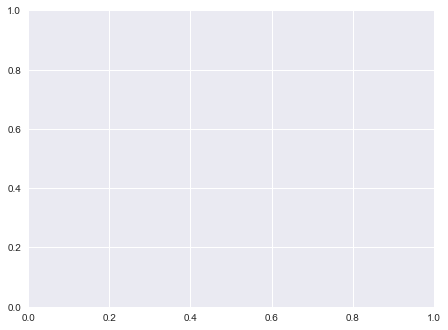

In [4]:
plt.figure(figsize=(16,12))

plt.subplot(2, 2, 1)
results.rss.plot(title='RSS', lw=1, color='blue')

plt.subplot(2, 2, 2)
max_r2a = results.r2a.argmax()-1
results.r2a.plot(title='Adj. $R^2$', markevery=[max_r2a], marker='D', lw=1, color='red')

plt.subplot(2, 2, 3)
min_aic = results.aic.argmin()-1
results.aic.plot(title='AIC', markevery=[min_aic], marker='D', lw=1, color='green')

plt.subplot(2, 2, 4)
min_bic = results.bic.argmin()-1
results.bic.plot(title='BIC', markevery=[min_bic], marker='D', lw=1, color='purple');

In [12]:
bic_reg = sm.OLS(y, sm.add_constant(X.iloc[:, [0, 1, 5, 11, 14, 15]])).fit()
bic_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     44.18
Date:                Sat, 05 Aug 2017   Prob (F-statistic):           6.82e-37
Time:                        21:21:52   Log-Likelihood:                -1886.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     256   BIC:                             3812.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.4397     64.050     -0.491      0.624    -157.571      94.692
AtBat         -1.8686      0.527     -3.543      0.000      -2.907      -0.830
Hits           7.6044      1.663      4.574      0.000       4.330      10.878
Walks          3.6976      1.210      3.055      0.002       1.314       6.081
CRBI           0.6430      0.064      9.979      0.000       0.516       0.770
Division     122.9515     39.820      3.088      0.002      44.534     201.369
PutOuts        0.2643      0.075      3.535      0.000       0.117       0.412
==============================================================================
Omnibus:                      101.319   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              615.052
Skew:                           1.411   Prob(JB):                    2.77e-134
Kurtosis:                       9.940   Cond. No.                     2.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 6.5.2 Forward and Backward Stepwise Selection

This section is a shameless copy-paste from: http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8/Lab%208%20-%20Subset%20Selection%20in%20Python.pdf as they were pretty well structured. I made some small adaptations, that's it.

In [9]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = regr.ssr
    return {'model': regr, 'RSS': RSS}

In [10]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
      
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward(predictors):
    
    results = []
    
    for combo in combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    return best_model

Forward Selection:

In [11]:
models2 = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):    
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]['model'].model.exog_names

bic_f = []

for m in models2.model:
    bic_f.append(m.bic)
    
np.array(bic_f).argmin()

5

Backward Selection:

In [12]:
models3 = pd.DataFrame(columns=['RSS', 'model'], index = range(1, len(X.columns)))

predictors = X.columns

while(len(predictors) > 1):  
    models3.loc[len(predictors)-1] = backward(predictors)
    predictors = models3.loc[len(predictors)-1]['model'].model.exog_names
    
bic_b = []

for m in models3.model:
    bic_b.append(m.bic)
    
np.array(bic_b).argmin()

7

# 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

Heavily borrowed from:

https://nbviewer.jupyter.org/url/www.science.smith.edu/~jcrouser/SDS293/labs/lab9/Lab%209%20-%20Linear%20Model%20Selection%20in%20Python.ipynb

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

In [14]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {'model':regr, 'RSS':RSS}

In [15]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [16]:
models_train = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    predictors = models_train.loc[i]['model'].model.exog_names

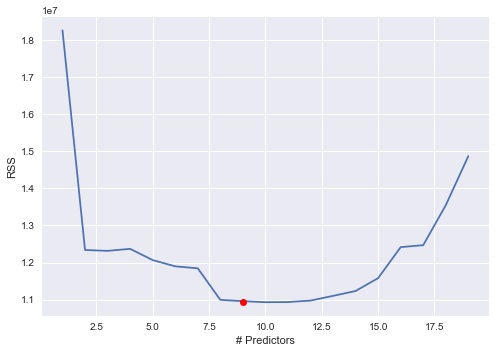

In [17]:
plt.plot(models_train['RSS'])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train['RSS'].argmin(), models_train['RSS'].min(), 'or');

In [18]:
models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,20):    
    models_full.loc[i] = forward(predictors, X, y, X, y)
    predictors = models_full.loc[i]['model'].model.exog_names

In [19]:
print(models_train.loc[10, 'model'].model.exog_names)
print(models_full.loc[10, 'model'].model.exog_names)

['CRuns', 'PutOuts', 'CWalks', 'Runs', 'CRBI', 'League', 'AtBat', 'Hits', 'Division', 'Assists']
['Hits', 'CRBI', 'PutOuts', 'AtBat', 'Division', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']


In [51]:
#TODO cross validation